In [20]:
import copy
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

from src.utils import load_all_csv_in_dir

In [24]:
data_dir = os.path.join("..", "PythonAnygrad", "save")
data = load_all_csv_in_dir(data_dir)
data = data.dropna(subset=["value"]).sort_values(by="total_iterations")

strategies = np.unique(data["strategy"])
targets = np.unique(data["target"])
num_strategies = len(strategies)
num_targets = len(targets)

data

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
4,"Baseline (round robin, m=100)",0,1,Target 1,-1046.105472,100,100,100,5.588790,0.691354,-0.691353,0.006914,NaN,NaN,NaN
4,Anygrad (m=150),0,1,Target 1,-1044.718270,150,150,150,5.622330,0.770696,-0.770696,0.005138,NaN,NaN,NaN
9,"Baseline (round robin, m=100)",0,2,Target 2,-1068.048224,100,100,200,11.013351,0.529707,5.059044,0.005297,NaN,NaN,NaN
4,"Baseline (round robin, m=200)",0,1,Target 1,-987.923803,200,200,200,5.945011,1.041810,-1.041810,0.005209,NaN,NaN,NaN
8,"Baseline (round robin, m=100)",0,2,Target 1,-1046.105472,100,100,200,5.588790,0.691354,-0.691353,0.006914,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,"Baseline (round robin, m=1000)",0,91,Target 1,-898.186695,1000,23000,91000,896.741371,118.935987,4.865433,0.005141,-0.000070,2.868345e-09,-0.006874
371,"Baseline (round robin, m=1000)",0,92,Target 4,-903.953973,1000,23000,92000,927.071806,118.928483,4.962384,0.005151,-0.000786,2.082082e-08,-0.076738
370,"Baseline (round robin, m=1000)",0,92,Target 3,-893.822156,1000,23000,92000,917.056011,119.189477,4.979569,0.005158,-0.000037,1.306334e-09,-0.003581
369,"Baseline (round robin, m=1000)",0,92,Target 2,-894.999595,1000,23000,92000,906.991639,118.917999,4.881088,0.005165,0.000183,-3.771177e-09,0.018004


## Raw results
First plot the loss of each target over time

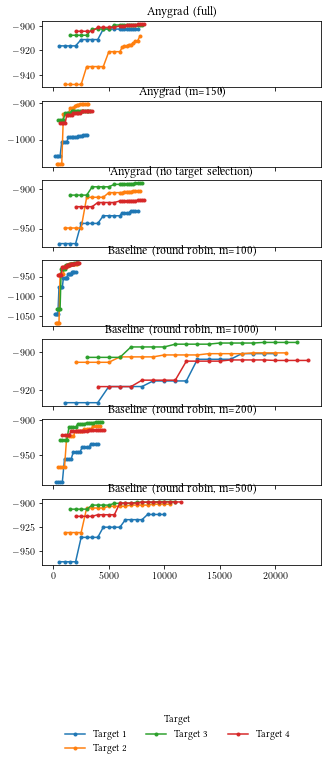

In [25]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_iterations"][:20], target_data["value"][:20], label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

## Imputation

1. We prepend the first non-nan value for each target of each strategy
2. For each timestamp in the data of one strategy we impute the value with the last one measured

In [9]:
def prepend_first_rows(df: pd.DataFrame) -> pd.DataFrame:
    for strategy in np.unique(df["strategy"]):
        for target in np.unique(df["target"]):
            filter_arr = np.logical_and(df["target"] == target, df["strategy"] == strategy)
            first_row = copy.deepcopy(df[filter_arr]).iloc[[0]]
            first_row["total_time"] = 0.0
            first_row["total_iterations"] = 0.0
            first_row["M"] = 0
            first_row = pd.DataFrame(first_row, columns=df.columns)
            df = pd.concat([first_row, df], ignore_index=True)
    return df

data = prepend_first_rows(data)
data.sort_values(by="total_time", inplace=True)

## Compute AUC

For convenience averaging, we use a numpy array

In [13]:
def compute_auc(x, y):
    x = np.array(x)
    y = -np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]))
            for i in range(1, len(y), 1)]
    return x[1:], area

num_values = []
for strategy in strategies:
    strategy_arr = []
    for target in targets:
        filter_arr = np.logical_and(data["strategy"] == strategy, data["target"] == target)
        num_values.append(np.sum(filter_arr))
max_num_values = np.max(num_values)

auc_arr = np.empty(shape=(num_strategies, num_targets, 2, max_num_values), dtype=float)
auc_arr.fill(np.nan)
for i, strategy in enumerate(strategies):
    for t, target in enumerate(targets):
        filter_arr = np.logical_and(data["strategy"] == strategy, data["target"] == target)
        target_data = data[filter_arr]
        x = target_data["total_time"]
        y = target_data["value"]
        x, auc = compute_auc(x, y)
        auc_arr[i, t, 0, :len(x)] = x
        auc_arr[i, t, 1, :len(x)] = auc
auc_arr

array([[[[7.51623232e+00, 7.51623232e+00, 7.51623232e+00, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 6.88785579e+03, 6.88785579e+03, ...,
                     nan,            nan,            nan]],

        [[1.49858906e+01, 1.49858906e+01, 1.49858906e+01, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 1.42031214e+04, 1.42031214e+04, ...,
                     nan,            nan,            nan]],

        [[2.29652166e+01, 2.29652166e+01, 2.29652166e+01, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 2.08468856e+04, 2.08468856e+04, ...,
                     nan,            nan,            nan]],

        [[3.09146110e+01, 3.09146110e+01, 3.09146110e+01, ...,
                     nan,            nan,            nan],
         [0.00000000e+00, 2.79624112e+04, 2.79624112e+04, ...,
                     nan,            nan,            nan]]],


       [[[5.62

## AUC

Plot all auc values

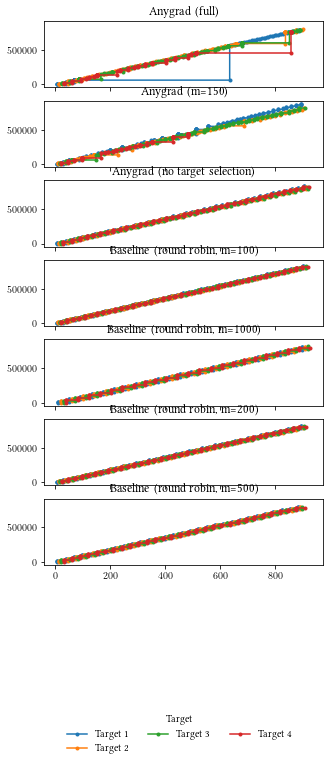

In [17]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", sharey="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for t, target in enumerate(targets):
        x = auc_arr[i, t, 0]
        y = auc_arr[i, t, 1]
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(x, y, label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_time"], target_data["value"], label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

## Average

Compute Average over all targets per strategy

In [ ]:
grouped_data = data.groupby(by="strategy")
for strategy in strategies:
    strategy_data = grouped_data.get_group(strategy)
    unique_timestamps = np.unique(strategy_data["total_time"])
    grouped_data_by_timestamp = strategy_data.groupby("total_time")
    for timestamp in unique_timestamps:
        timestamp_data: pd.DataFrame = grouped_data_by_timestamp.get_group(timestamp)
        timestamp_data.mean()



In [ ]:
alpha = 0.5

In [ ]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    for target in targets:
        target_data = this_data[this_data["target"] == target]
        axes[0].plot(target_data["total_time"], target_data["efficiency"], label=target, alpha=alpha, marker="o")
        axes[1].plot(target_data["total_time"], target_data["M"], label=target, alpha=alpha, marker="o")
        axes[2].plot(target_data["total_time"], target_data["value"], label=target, alpha=alpha, marker="o")
        axes[0].set_title(strategy)
    axes[0].set_ylabel("Efficiency")
    axes[1].set_ylabel("M")
    axes[2].set_ylabel("Value")
    axes[-1].set_xlabel("Execution time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [ ]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    reps = np.unique(this_data["rep"])
    for target in targets:
        for rep in reps:
            target_data = this_data[np.logical_and(this_data["target"] == target, this_data["rep"] == rep)]
            axes[0].plot(target_data["total_time"], target_data["derivation_1st"] / target_data["t1"],
                         label=target, alpha=alpha, marker="x")
            axes[1].plot(target_data["total_time"], target_data["derivation_2nd"],
                         label=target, alpha=alpha, marker="x")
            axes[2].plot(target_data["total_time"], target_data["m"],
                         label=target, alpha=alpha, marker="x")
            axes[0].set_title(strategy)
    axes[0].set_ylabel("1st derivation")
    axes[1].set_ylabel("2nd derivation")
    axes[2].set_ylabel("value")
    axes[-1].set_xlabel("Execution Time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [ ]:
def compute_auc_remaining(x, y, offset: float):
    x = np.array(x)
    y = np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = np.nanmin(y) - y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]) + offset*(x[i-1]-x[0]))
            for i in range(1, len(y), 1)]
    return x[1:], area

def group_df(df: pd.DataFrame):
    df = df.sort_values(by="total_iterations").groupby(by=["strategy", "target"])
    return df

In [ ]:
imputed_data = prepare_data(data)

In [ ]:
imputed_data

In [ ]:
unique_strategies = np.unique(data["strategy"])
unique_targets = np.unique(data["target"])
dataframes = []
for strategy in unique_strategies:
    df = None
    data_for_strategy = imputed_data[imputed_data["strategy"] == strategy].groupby("target")
    for target in unique_targets:
        current_data = data_for_strategy.get_group(target)
        x, y = compute_auc(current_data["total_time"], current_data["value"])
        entries = np.array([[target for _ in x], x, y])
        df = entries.T if df is None else np.vstack([df, entries.T])
    df = pd.DataFrame(df, columns=["target", "total_time", "value"])
    dataframes.append(df)


In [ ]:
for df, strategy in zip(dataframes, unique_strategies):
    grouped_dataframe = df.groupby(by="target")
    total_time = np.array(df["total_time"], dtype=float)
    values = np.array(df["value"], dtype=float)
    x = np.array(np.unique(total_time), dtype=float)
    print(len(x))
    x.sort()
    y = [np.nanmean(values[total_time == ts]) for ts in x]
    plt.plot(x[150:200], y[150:200], label=strategy)
plt.legend()
plt.show()

In [ ]:
min_losses = [np.nanmin(df["value"]) for df in df_per_strategy]
offsets = np.array(min_losses) - np.nanmin(min_losses)
offset = np.nanmax(min_losses)
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc_remaining(x, y, offset=offsets[i])
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Average AUC in $[T_0, T]$")
plt.show()


In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    plt.scatter(x, y, label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Running mean in $[T_0, T]$")
plt.show()

In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc(x, y)
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"AU Loss Curve in $[T_0, T]$")
plt.show()